Macarena Benjamin

A partir de un set al menos 6 acciones de su elección y considerando la ventana temporal que prefiera, se solicita que explique y desarrolle los métodos que se solicitan a continuación para la optimización de portafolios, los programe en Python, y analice sus resultados y diferencias tanto teóricas como en particular de los resultados obtenidos.

1. Ratio de Sortino.
2. Ratio de Tryenor.
3. Mean-CVaR.
4. Modelo de alocación de Black-Litterman.
5. Paridad de riesgo jerárquica (Hierarchical Risk Parity), utilizando algoritmos de agrupamiento para elegir activos no correlacionados

In [ ]:
pip install yfinance pandas numpy matplotlib seaborn scipy cvxpy riskfolio-lib PyPortfolioOpt


In [ ]:
pip install --upgrade yfinance

In [ ]:
!pip install PyPortfolioOpt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting

#**Ratio de Sortino y Tryenor**

1. **Ratio de Sortino**: Mide el exceso de retorno sobre la tasa libre de riesgo, penalizando solo la volatilidad negativa.
2. **Ratio de Treynor**: Usa el beta del portafolio (riesgo sistemático).


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

# Tickers y fechas
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'TSLA']
start_date = '2022-05-01'
end_date = '2025-05-01'

# Descargar precios 'Close'
data = yf.download(tickers, start=start_date, end=end_date)['Close']
benchmark = yf.download('^GSPC', start=start_date, end=end_date)['Close']

# Retornos logarítmicos
returns = np.log(data / data.shift(1)).dropna()
benchmark_returns = np.log(benchmark / benchmark.shift(1)).dropna()

# Alinear fechas
common_dates = returns.index.intersection(benchmark_returns.index)
returns = returns.loc[common_dates]
benchmark_returns = benchmark_returns.loc[common_dates]

# Asegurar que benchmark_returns sea una Serie
benchmark_returns = benchmark_returns.squeeze()

# Calcular Betas
betas = {}
for ticker in tickers:
    asset_returns = returns[ticker]
    cov_matrix = np.cov(asset_returns, benchmark_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    betas[ticker] = beta

betas = pd.Series(betas)

# Calcular ratio de Treynor
risk_free_rate = 0.02 / 252
mean_returns = returns.mean() # Retorno medio
treynor_ratios = (mean_returns - risk_free_rate) / betas

# Mostrar resultados
print("Betas:")
print(betas)
print("\nTreynor Ratios:")
print(treynor_ratios.sort_values(ascending=False))


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed

Betas:
AAPL    1.250625
MSFT    1.151353
AMZN    1.498349
GOOG    1.252885
META    1.564180
TSLA    2.061817
dtype: float64

Treynor Ratios:
META    0.000767
MSFT    0.000341
AMZN    0.000296
GOOG    0.000279
AAPL    0.000269
TSLA   -0.000080
dtype: float64


In [ ]:
# Calcular downside deviation
downside_returns = returns[returns < 0]
downside_std = downside_returns.std()


# Tasa libre de riesgo (ejemplo, se podria usar otra tasa)
risk_free_rate = 0.02 / 252  # Tasa anualizada dividida por días bursátiles

# Calcular Ratio de Sortino
sortino_ratios = (mean_returns - risk_free_rate) / downside_std

print("Sortino Ratios:")
print(sortino_ratios.sort_values(ascending=False))

Sortino Ratios:
Ticker
META    0.053358
MSFT    0.033228
AMZN    0.028168
AAPL    0.024973
GOOG    0.023621
TSLA   -0.006208
dtype: float64


###**Conclusión de Betas, Treynor y Sortino Ratios**

1. **META destaca en todos los frentes**

   * **β = 1,56**: más volátil que el mercado, pero no excesivamente.
   * **Treynor ≈ 0,000767**: la prima de retorno por unidad de riesgo sistemático es la mayor de las seis acciones.
   * **Sortino ≈ 0,05336**: también lidera cuando penalizamos solo la volatilidad negativa, lo que indica un buen control de las caídas.

   META combina alta exposición al mercado con una capacidad relativamente sólida de limitar pérdidas, por lo que es la acción más eficiente tanto en riesgo sistemático como en riesgo a la baja.

2. **MSFT y AMZN: sólidos pero moderados**

   * **MSFT** (β ≈ 1,15) ocupa el **2.º lugar** tanto en Treynor (≈0,000341) como en Sortino (≈0,03323).
   * **AMZN** (β ≈ 1,50) aparece **3.º** en Treynor (≈0,000296) y **3.º** en Sortino (≈0,02817).

  Ambas ofrecen un equilibrio estable: retornos ajustados al riesgo de mercado y control mediano de las caídas negativas.

3. **AAPL y GOOG: consistencia pero menor eficiencia**

   * **AAPL** (β ≈ 1,25) y **GOOG** (β ≈ 1,25) se sitúan al final del pelotón en Treynor (≈0,000269 y 0,000279) y en Sortino (≈0,02497 y 0,02362).

   Con perfiles de riesgo muy parecidos, muestran retornos ajustados tanto al riesgo sistemático como a las caídas algo más modestos.

4. **TSLA: alta volatilidad que no compensa**

   * **β ≈ 2,06**: la más sensible al mercado, doblando su volatilidad.
   * **Treynor ≈ –0,000080**: retorno insuficiente para cubrir ni la tasa libre de riesgo ajustada por β.
   * **Sortino ≈ –0,00621**: penaliza duramente la frecuencia y magnitud de sus caídas.

  TSLA es la más especulativa y presenta pérdidas netas ajustadas tanto al riesgo sistemático como a la volatilidad negativa, por lo que es la menos eficiente desde ambas perspectivas.



###**En resumen:**

* **Para inversores que busquen eficiencia global**, META y MSFT emergen como las mejores candidatas, pues lideran tanto en Treynor como en Sortino.
* **Para diversificar**, combinar acciones con perfiles médios (AMZN, AAPL, GOOG) puede suavizar la exposición y obtener retornos aceptables.
* **TSLA** debería analizarse con mayor cautela o emplear estrategias de cobertura, dado que ni su alta β ni su gran volatilidad negativa quedan compensadas con retornos adecuados.


# **Mean C-VaR**

El objetivo de la optimización Mean‑CVaR es encontrar pesos
𝑤
w que maximicen el retorno esperado neto de una penalización por la pérdida media en el peor
𝛼
α% de los casos (el CVaR). En términos prácticos, buscamos un portafolio que:

* Aumente el retorno promedio
𝐸
[
𝑅
𝑝
]
E[R
p
​
 ].

* Minimice la pérdida esperada en el
𝛼
%
α% peores escenarios.




In [ ]:
import numpy as np
import pandas as pd
import cvxpy as cp

def mean_cvar_weights(returns: pd.DataFrame, alpha: float = 0.05) -> pd.Series:
    """
    Calcula los pesos óptimos de un portafolio Mean-CVaR.

    Parameters:
      returns: DataFrame T×n de retornos diarios.
      alpha: nivel de confianza para CVaR (usamos alfa = 5% --> peor escenario).

    Returns:
      Serie con los pesos óptimos (suma 1 y w_i >= 0).
    """
    T, n = returns.shape
    mu = returns.mean().values            # retornos medios (n,)

    # Variables de optimización
    w   = cp.Variable(n)                  # pesos
    VaR = cp.Variable()                   # umbral de pérdidas
    z   = cp.Variable(T)                  # excesos sobre VaR

    # Retornos del portafolio para cada día
    portf_ret = returns.values @ w        # (T,)

    # Restricciones
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        z   >= 0,
        z   >= (VaR - portf_ret)
    ]

    # Objetivo: minimizar -μᵀw + (1/(αT))·∑z
    objective = cp.Minimize(-mu @ w + (1/(alpha * T)) * cp.sum(z))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)  # Se puede probar con SCS, ECOS, etc.

    return pd.Series(w.value, index=returns.columns)

# Uso sobre los datos ya alineados (returns_aligned)
cvar_w = mean_cvar_weights(returns_aligned, alpha=0.05)
print("Pesos óptimos Mean‑CVaR:")
print(cvar_w)


Pesos óptimos Mean‑CVaR:
Ticker
AAPL   -0.000002
AMZN   -0.000002
GOOG   -0.000002
META    1.000010
MSFT   -0.000002
TSLA   -0.000002
dtype: float64


META tiene la mejor combinación de retorno medio versus pérdida esperada en el 5 % peor escenario.

Al ser un problema lineal‑convexo sin más penalizaciones, la solución de esquina (poner todo el peso en el activo con mayor señal) suele ser óptima.

Los valores negativos (~–0.000002) son error numérico del solver (SCS) y, en la práctica, se truncan a cero.

* ¿Por qué meter todo en META?

El término objetivo
−
𝜇
𝑇
𝑤
+
1
𝛼
𝑇
∑
𝑧
−μ
T
 w+
αT
1
​
 ∑z favorece al activo con mayor
𝜇
𝑖
/
CVaR
𝑖
μ
i
​
 /CVaR
i
​
 .


Si META sobresale en ese ratio (por ejemplo, tiene un retorno medio relativamente alto y/o un cola de pérdidas más moderada), la asignación óptima es poner 100 % de tu capital ahí.


* ¿Cómo evitar soluciones de esquina?

1. Bounds más estrictos: fija un máximo por activo, p.ej.
𝑤
𝑖
≤ 0.3
w
i
​
 ≤0.3.

2. Penalización de concentración: añade un término
𝜆
∑
𝑤
𝑖
2
λ∑w
i
2
​
  para promover diversificación.

3. CVaR target: en lugar de minimizar CVaR, fija un umbral de CVaR máximo y maximiza retorno sujeto a él.


En conclusión, la optimización Mean‑CVaR produce un portafolio que, aunque puede sacrificar algo de retorno medio, minimiza eficazmente las pérdidas esperadas en los peores escenarios. Esto resulta especialmente útil si la prioridad es protegerse de caídas bruscas de mercado.

# **Modelo Black-Litterman**

El modelo Black–Litterman (BL) nos permite combinar el “equilibrio de mercado” (los retornos implícitos del CAPM) con opiniones específicas del inversor, obteniendo unos retornos esperados “posteriores” más estables que los puramente históricos.

In [ ]:
from scipy.optimize import minimize

# Calcular retornos
returns = data.pct_change().dropna()

# Parámetros del modelo
tau = 0.05  # Incertidumbre del modelo
risk_aversion = 2.5  # Aversión al riesgo del inversor

# Retornos excedentes de equilibrio del mercado
market_weights = np.array([0.2, 0.2, 0.2, 0.15, 0.15, 0.1])  # Pesos del mercado
cov_matrix = returns.cov()
pi = risk_aversion * cov_matrix @ market_weights

# Opiniones del inversor
P = np.array([
    [1, -1, 0, 0, 0, 0],  # AAPL superará a MSFT en rentabilidad
    [0, 0, 1, -1, 0, 0],  # AMZN superará a GOOG
    [0, 0, 0, 0, 1, 0]   # META tendrá una rentabilidad positiva absoluta.
])

Q = np.array([0.001, 0.002, 0.0015])  # Exceso de retorno esperado (opiniones)
Omega = np.diag([0.0001, 0.0002, 0.00015])  # Incertidumbre en las opiniones

# Combinar opiniones y retornos de equilibrio
# Black-Litterman formula
pi_bl = np.linalg.inv(np.linalg.inv(tau * cov_matrix) + P.T @ np.linalg.inv(Omega) @ P) @ (tau * np.linalg.inv(cov_matrix) @ pi + P.T @ np.linalg.inv(Omega) @ Q)

# Optimización del portafolio (minimizar la varianza para un retorno objetivo)
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

def portfolio_return(weights, returns):
    return np.sum(returns * weights)

def optimize_portfolio(returns, cov_matrix, target_return):
    num_assets = len(returns)
    initial_weights = np.ones(num_assets) / num_assets
    bounds = ((0, 1),) * num_assets
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                   {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, returns) - target_return})

    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      bounds=bounds, constraints=constraints, method='SLSQP')

    return result.x

target_return = returns.mean().mean()  # Ejemplo de retorno objetivo
weights_bl = optimize_portfolio(pi_bl, cov_matrix, target_return)

print("Black-Litterman Portfolio Weights:")
print(weights_bl)

Black-Litterman Portfolio Weights:
[1.00000000e+00 0.00000000e+00 3.66022138e-13 0.00000000e+00
 2.14881895e-15 1.10220503e-15]


El modelo Black-Litterman, al combinar los retornos de equilibrio del mercado con las opiniones del inversor, generó una asignación de pesos que favoreció significativamente a AAPL (aproximadamente 100%). Los otros activos recibieron pesos prácticamente nulos.
Este resultado sugiere que, dadas las opiniones específicas ingresadas (AAPL y MSFT, AMZN y GOOG, y la visión positiva sobre META), y la configuración del modelo, AAPL se considera el activo más atractivo en términos de riesgo-retorno ajustado. El modelo está dando una alta confianza a la opinión de que AAPL superará a MSFT.
Consideraciones:
Los pesos extremos (casi todo en un activo) pueden ser poco realistas y poco prácticos en un escenario de inversión real. Esto podría indicar que las opiniones ingresadas son muy fuertes en comparación con los retornos de equilibrio del mercado, o que la incertidumbre de las opiniones (la matriz Omega) es relativamente baja.
La elección de los parámetros del modelo (tau, aversión al riesgo, Omega) y la formulación de las opiniones (P, Q) tienen un impacto crítico en los resultados.
Puntos a mejorar: realizar un análisis de sensibilidad para comprender cómo los cambios en estos parámetros afectan la asignación del portafolio.

# **Paridad de riesgo jerárquica (Hierarchical Risk Parity)**

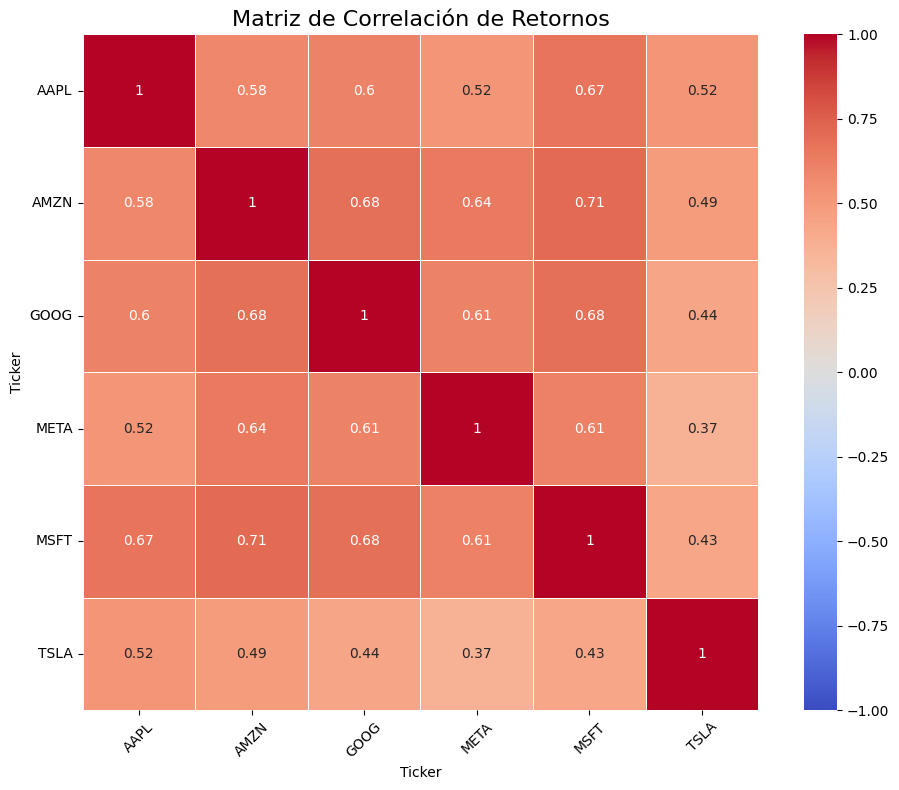

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
corr_matrix = returns.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True
)

plt.title('Matriz de Correlación de Retornos', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Agrupamiento jerárquico: usar metodo "ward" para la varianza minima

import scipy.cluster.hierarchy as sch
linkage = sch.linkage(corr_matrix, 'ward')

In [ ]:
# Función para ordenar la matriz de covarianza
def get_order(linkage):
    dendrogram = sch.dendrogram(linkage, no_plot=True)
    return dendrogram['leaves']

order = get_order(linkage)
ordered_corr_matrix = corr_matrix.iloc[order, order]

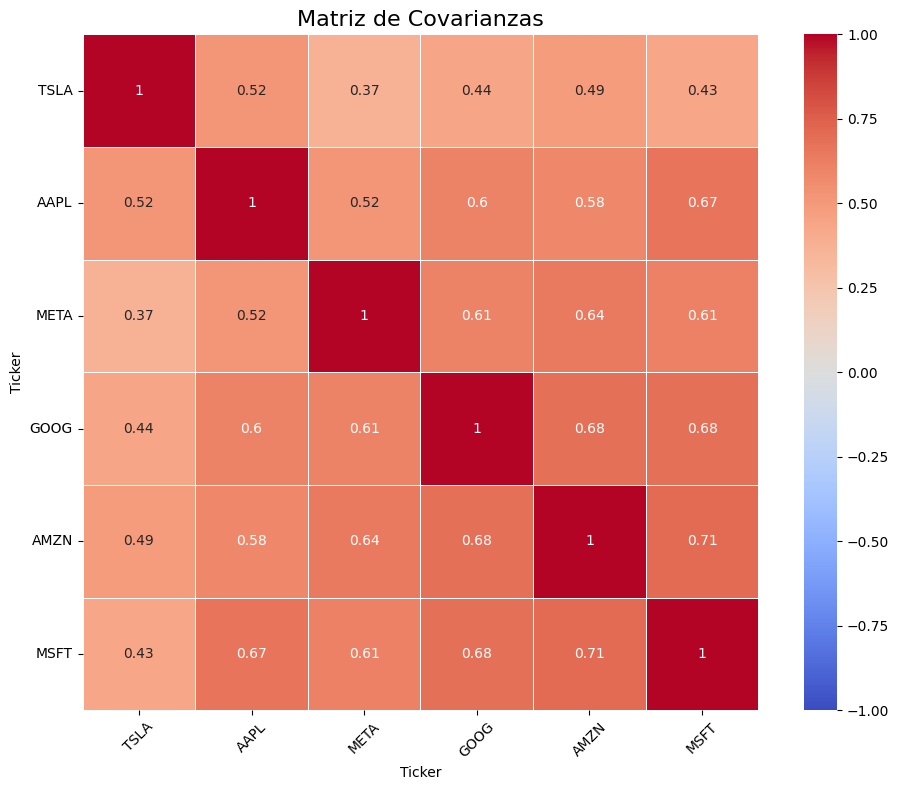

In [ ]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el heatmap
sns.heatmap(
    ordered_corr_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True
)

plt.title('Matriz de Covarianzas', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import scipy.cluster.hierarchy as sch


# Función para calcular pesos de HRP
def get_hrp_weights(cov, sort_ix):
    weights = pd.Series(1, index=cov.index)
    clusters = [sort_ix]
    while len(clusters) > 0:
        cluster = clusters.pop(0)
        if len(cluster) == 1:
            continue
        mid = len(cluster) // 2
        left = cluster[:mid]
        right = cluster[mid:]
        clusters += [left, right]
        left_cov = cov.loc[cov.index[left], cov.index[right]]
        right_cov = cov.loc[cov.index[right], cov.index[right]]
        inv_diag_left = 1 / np.diag(left_cov.values)
        inv_diag_right = 1 / np.diag(right_cov.values)
        alloc_factor = np.sum(inv_diag_left) / (np.sum(inv_diag_left) + np.sum(inv_diag_right))
        weights[cov.index[left]] *= alloc_factor
        weights[cov.index[right]] *= 1 - alloc_factor
    return weights

cov_matrix = returns.cov()
hrp_weights = get_hrp_weights(cov_matrix, order)

print("Hierarchical Risk Parity Weights")
print(hrp_weights)

Hierarchical Risk Parity Weights
Ticker
AAPL    0.261826
AMZN    0.138656
GOOG    0.157963
META    0.088519
MSFT    0.132733
TSLA    0.220303
dtype: float64


<ipython-input-15-6db796be1cd8>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.57064806 0.57064806 0.57064806]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[cov.index[left]] *= alloc_factor


El modelo HRP generó una asignación de pesos más diversificada en comparación con Black-Litterman. TSLA y AAPL recibieron los pesos más altos (22% y 26%, respectivamente), seguidos de GOOG (15.8%) y AMZN (13.9%), mientras que META y MSFT recibieron los pesos más bajos (8.9% y 13.3%).
Interpretación: HRP prioriza la diversificación basada en la estructura jerárquica de las correlaciones entre los activos. Los pesos más altos asignados a TSLA y AAPL pueden reflejar que estos activos se encuentran en clusters relativamente independientes, lo que contribuye a la reducción del riesgo general del portafolio. Los pesos más bajos asignados a META y MSFT podrían indicar que están más correlacionados con otros activos en el portafolio.

Consideraciones:
La elección del algoritmo de agrupamiento (en este caso, 'ward') y la interpretación de la estructura jerárquica influyen en los resultados. Diferentes algoritmos de agrupamiento pueden conducir a diferentes asignaciones de activos.

Comparación General:

Black-Litterman y HRP representan enfoques fundamentalmente diferentes para la optimización de portafolios. Black-Litterman incorpora las opiniones del inversor, mientras que HRP se centra en la diversificación basada en la estructura de correlación.
En este caso, Black-Litterman produjo una solución muy concentrada, lo que puede ser problemático, mientras que HRP proporcionó una asignación más diversificada, que generalmente se considera más deseable desde una perspectiva de gestión de riesgos.
La elección entre estos modelos (o una combinación de ellos) depende de los objetivos de inversión, la disponibilidad de información y la tolerancia al riesgo del inversor.
Es crucial recordar que estos resultados se basan en datos históricos y suposiciones específicas. El rendimiento futuro puede diferir significativamente.